## Transfer MNIST-M domain adaptation to Fashion MIST Images

In [1]:
from __future__ import print_function, division
import scipy
import pandas as pd
import numpy as np
import os
#from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils import to_categorical
import datetime
import matplotlib.pyplot as plt
import sys
import scipy
from glob import glob
from keras.datasets import mnist
from skimage.transform import resize as imresize
import pickle
import os
import urllib
import gzip

C:\Users\kenneth\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class DataLoader():
    """Loads images from MNIST (domain A) and MNIST-M (domain B)"""
    def __init__(self, img_res=(28, 28)):
        self.img_res = img_res

        self.mnistm_url = 'https://github.com/VanushVaswani/keras_mnistm/releases/download/1.0/keras_mnistm.pkl.gz'

        self.setup_mnist(img_res)
        self.setup_mnistm(img_res)

    def normalize(self, images):
        return images.astype(np.float32) / 127.5 - 1.

    def setup_mnist(self, img_res):

        print ("Setting up MNIST...")

        if os.path.exists('datasets/mnist_x.npy'):
            # Load the dataset
            (mnist_X, mnist_y), (_, _) = fashion_mnist.load_data()

            # Normalize and rescale images
            mnist_X = self.normalize(mnist_X)
            mnist_X = np.array([imresize(x, img_res) for x in mnist_X])
            mnist_X = np.expand_dims(mnist_X, axis=-1)
            mnist_X = np.repeat(mnist_X, 3, axis=-1)

            self.mnist_X, self.mnist_y = mnist_X, mnist_y

            # Save formatted images
            np.save('datasets/mnist_x.npy', self.mnist_X)
            np.save('datasets/mnist_y.npy', self.mnist_y)
        else:
            self.mnist_X = np.load('datasets/mnist_x.npy')
            self.mnist_y = np.load('datasets/mnist_y.npy')

        print ("+ Done.")

    def setup_mnistm(self, img_res):

        print ("Setting up MNIST-M...")

        if not os.path.exists('datasets/mnistm_x.npy'):

            # Download the MNIST-M pkl file
            filepath = 'datasets/keras_mnistm.pkl.gz'
            if not os.path.exists(filepath.replace('.gz', '')):
                print('+ Downloading ' + self.mnistm_url)
                data = urllib.request.urlopen(self.mnistm_url)
                with open(filepath, 'wb') as f:
                    f.write(data.read())
                with open(filepath.replace('.gz', ''), 'wb') as out_f, \
                        gzip.GzipFile(filepath) as zip_f:
                    out_f.write(zip_f.read())
                os.unlink(filepath)

            # load MNIST-M images from pkl file
            with open('datasets/keras_mnistm.pkl', "rb") as f:
                data = pickle.load(f, encoding='bytes')

            # Normalize and rescale images
            mnistm_X = np.array(data[b'train'])
            mnistm_X = self.normalize(mnistm_X)
            mnistm_X = np.array([imresize(x, img_res) for x in mnistm_X])

            self.mnistm_X, self.mnistm_y = mnistm_X, self.mnist_y.copy()

            # Save formatted images
            np.save('datasets/mnistm_x.npy', self.mnistm_X)
            np.save('datasets/mnistm_y.npy', self.mnistm_y)
        else:
            self.mnistm_X = np.load('datasets/mnistm_x.npy')
            self.mnistm_y = np.load('datasets/mnistm_y.npy')

        print ("+ Done.")


    def load_data(self, domain, batch_size=1):

        X = self.mnist_X if domain == 'A' else self.mnistm_X
        y = self.mnist_y if domain == 'A' else self.mnistm_y

        idx = np.random.choice(list(range(len(X))), size=batch_size)

        return X[idx], y[idx]

In [ ]:
class PixelDA():
    def __init__(self):
        # Input shape
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = 10

        # Configure MNIST and MNIST-M data loader
        self.data_loader = DataLoader(img_res=(self.img_rows, self.img_cols))

        # Loss weights
        lambda_adv = 10
        lambda_clf = 1

        # Calculate output shape of D (PatchGAN)
        #patch = int(self.img_rows / 2**4)
        patch = 2
        self.disc_patch = (patch, patch, 1)

        # Number of residual blocks in the generator
        self.residual_blocks = 6

        optimizer = Adam(0.0002, 0.5)

        # Number of filters in first layer of discriminator and classifier
        self.df = 64
        self.cf = 64

        # Build and compile the discriminators
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # Build the task (classification) network
        self.clf = self.build_classifier()

        # Input images from both domains
        img_A = Input(shape=self.img_shape)
        img_B = Input(shape=self.img_shape)

        # Translate images from domain A to domain B
        fake_B = self.generator(img_A)

        # Classify the translated image
        class_pred = self.clf(fake_B)

        # For the combined model we will only train the generator and classifier
        self.discriminator.trainable = False

        # Discriminator determines validity of translated images
        valid = self.discriminator(fake_B)

        self.combined = Model(img_A, [valid, class_pred])
        self.combined.compile(loss=['mse', 'categorical_crossentropy'],
                                    loss_weights=[lambda_adv, lambda_clf],
                                    optimizer=optimizer,
                                    metrics=['accuracy'])

    def build_generator(self):
        """Resnet Generator"""

        def residual_block(layer_input):
            """Residual block described in paper"""
            d = Conv2D(64, kernel_size=3, strides=1, padding='same')(layer_input)
            d = BatchNormalization(momentum=0.8)(d)
            d = Activation('relu')(d)
            d = Conv2D(64, kernel_size=3, strides=1, padding='same')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Add()([d, layer_input])
            return d

        # Image input
        img = Input(shape=self.img_shape)

        l1 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(img)

        # Propogate signal through residual blocks
        r = residual_block(l1)
        for _ in range(self.residual_blocks - 1):
            r = residual_block(r)

        output_img = Conv2D(self.channels, kernel_size=3, padding='same', activation='tanh')(r)

        return Model(img, output_img)


    def build_discriminator(self):

        def d_layer(layer_input, filters, f_size=4, normalization=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        d1 = d_layer(img, self.df, normalization=False)
        d2 = d_layer(d1, self.df*2)
        d3 = d_layer(d2, self.df*4)
        d4 = d_layer(d3, self.df*8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)

    def build_classifier(self):

        def clf_layer(layer_input, filters, f_size=4, normalization=True):
            """Classifier layer"""
            d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if normalization:
                d = InstanceNormalization()(d)
            return d

        img = Input(shape=self.img_shape)

        c1 = clf_layer(img, self.cf, normalization=False)
        c2 = clf_layer(c1, self.cf*2)
        c3 = clf_layer(c2, self.cf*4)
        c4 = clf_layer(c3, self.cf*8)
        c5 = clf_layer(c4, self.cf*8)

        class_pred = Dense(self.num_classes, activation='softmax')(Flatten()(c5))

        return Model(img, class_pred)

    def train(self, epochs, batch_size=128, sample_interval=50):

        half_batch = int(batch_size / 2)

        # Classification accuracy on 100 last batches of domain B
        test_accs = []

        # Adversarial ground truths
        valid = np.ones((batch_size, *self.disc_patch))
        fake = np.zeros((batch_size, *self.disc_patch))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            imgs_A, labels_A = self.data_loader.load_data(domain="B", batch_size=batch_size)
            imgs_B, labels_B = self.data_loader.load_data(domain="A", batch_size=batch_size)

            # Translate images from domain A to domain B
            fake_B = self.generator.predict(imgs_A)

            # Train the discriminators (original images = real / translated = Fake)
            d_loss_real = self.discriminator.train_on_batch(imgs_B, valid)
            d_loss_fake = self.discriminator.train_on_batch(fake_B, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # --------------------------------
            #  Train Generator and Classifier
            # --------------------------------

            # One-hot encoding of labels
            labels_A = to_categorical(labels_A, num_classes=self.num_classes)

            # Train the generator and classifier
            g_loss = self.combined.train_on_batch(imgs_A, [valid, labels_A])

            #-----------------------
            # Evaluation (domain B)
            #-----------------------

            pred_B = self.clf.predict(imgs_B)
            test_acc = np.mean(np.argmax(pred_B, axis=1) == labels_B)

            # Add accuracy to list of last 100 accuracy measurements
            test_accs.append(test_acc)
            if len(test_accs) > 100:
                test_accs.pop(0)


            # Plot the progress
#             print ( "%d : [D - loss: %.5f, acc: %3d%%], [G - loss: %.5f], [clf - loss: %.5f, acc: %3d%%, test_acc: %3d%% (%3d%%)]" % \
#                                             (epoch, d_loss[0], 100*float(d_loss[1]),
#                                             g_loss[1], g_loss[2], 100*float(g_loss[-1]),
#                                             100*float(test_acc), 100*float(np.mean(test_accs))))


            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                print ( "%d : [D - loss: %.5f, acc: %3d%%], [G - loss: %.5f], [clf - loss: %.5f, acc: %3d%%, test_acc: %3d%% (%3d%%)]" % \
                                            (epoch, d_loss[0], 100*float(d_loss[1]),
                                            g_loss[1], g_loss[2], 100*float(g_loss[-1]),
                                            100*float(test_acc), 100*float(np.mean(test_accs))))

    def sample_images(self, epoch):
        r, c = 2, 5

        imgs_A, _ = self.data_loader.load_data(domain="A", batch_size=5)

        # Translate images to the other domain
        fake_B = self.generator.predict(imgs_A)

        gen_imgs = np.concatenate([imgs_A, fake_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        #titles = ['Original', 'Translated']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                #axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % (epoch))
        plt.imread("images/%d.png" % (epoch))
        plt.show()
        plt.close()

Setting up MNIST...


C:\Users\kenneth\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


+ Done.
Setting up MNIST-M...
+ Done.


C:\Users\kenneth\Anaconda3\lib\site-packages\keras\engine\training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


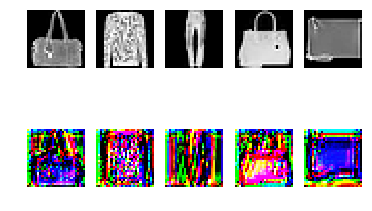

0 : [D - loss: 1.12666, acc:  31%], [G - loss: 6.27864], [clf - loss: 2.91182, acc:  12%, test_acc:  12% ( 12%)]


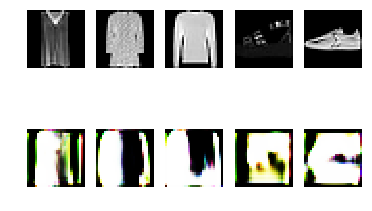

1000 : [D - loss: 0.05517, acc:  95%], [G - loss: 0.94542], [clf - loss: 1.70470, acc:  37%, test_acc:  25% ( 12%)]


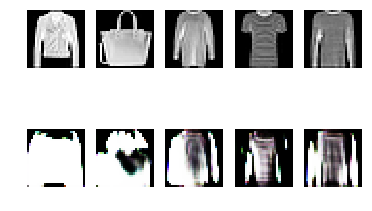

2000 : [D - loss: 0.07039, acc:  93%], [G - loss: 0.94446], [clf - loss: 0.66148, acc:  75%, test_acc:  12% ( 10%)]


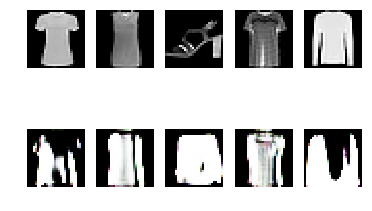

3000 : [D - loss: 0.02861, acc:  93%], [G - loss: 0.99392], [clf - loss: 2.24468, acc:  12%, test_acc:  12% ( 12%)]


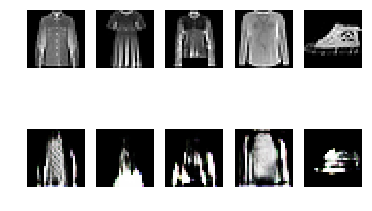

4000 : [D - loss: 0.03235, acc: 100%], [G - loss: 0.80056], [clf - loss: 1.08714, acc:  62%, test_acc:   0% ( 14%)]


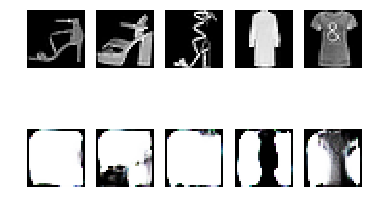

5000 : [D - loss: 0.05295, acc: 100%], [G - loss: 1.03695], [clf - loss: 0.59034, acc:  87%, test_acc:  25% ( 14%)]


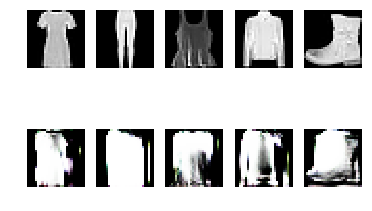

6000 : [D - loss: 0.02712, acc: 100%], [G - loss: 0.88877], [clf - loss: 1.12700, acc:  62%, test_acc:  25% ( 15%)]


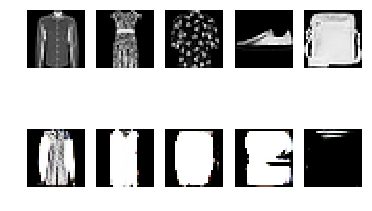

7000 : [D - loss: 0.01324, acc: 100%], [G - loss: 1.11586], [clf - loss: 1.37247, acc:  50%, test_acc:  37% ( 13%)]


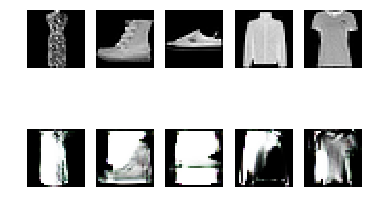

8000 : [D - loss: 0.06523, acc:  92%], [G - loss: 0.90813], [clf - loss: 0.72416, acc:  75%, test_acc:  12% ( 12%)]


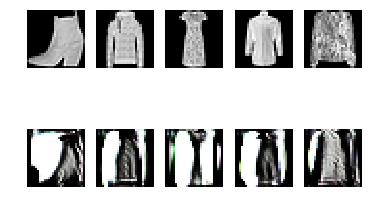

9000 : [D - loss: 0.04070, acc:  93%], [G - loss: 1.00180], [clf - loss: 0.63951, acc:  75%, test_acc:  12% ( 14%)]


In [4]:
gan = PixelDA()
gan.train(epochs=10000, batch_size=8, sample_interval=1000)
